# Error study

In this file I study the error of the algorithm. Since there is a big error coming from the thermalization it makes no sense to be extremely precise in the subsequent TEBD. What I require is to have the maximum error to be less than 0.1% and get the right values for the tolerance and cutoff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [2]:
### PROBLEM PARAMETERS
L = 7         # chain length
omega = 1     # Rabi frequency
V = 0.5       # B-S interaction strength
V_ = 0.5      # bath interaction strength
beta = 0.01   # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

tolerance = 1e-3 # Trotter
cutoff = 1e-6 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

In [3]:
def calculate_error(L, omega, V, V_, beta, T, dt, cutoff, img_cutoff, tolerance):
    ### BUILDING THE HAMILTONIAN

    # fisrt I build the operators
    nn_op = (I + Z)/2 & (I + Z)/2

    print(f'Building Hamiltonian for L={L}')
    # the hamiltonian
    H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
    H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
    H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

    H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

    # diagonalization
    e, U = la.eig(H, isherm=True)

    #print('done :)')
    
    ### BUILDING THE OBSERVABLES

    observables_ex = {}
    results_ex = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_ex[key] = []
        observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

    # dropping the identity
    observables_ex.pop('I1I2')
    results_ex.pop('I1I2')


    ### INITIAL CONDITIONS
    print('Initial state: random subsystem and thermal bath\n')

    #rho = la.expm(-beta*H)
    #rho /= rho.trace()

    rho = qu.gen.states.thermal_state(H, beta)

    # apply a random operator to the first two spins
    rand1 = qu.gen.rand.rand_uni(2)
    rand2 = qu.gen.rand.rand_uni(2)
    U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
    rho = U_rand @ rho @ U_rand.H

    ### THE SIMULATION

    # smarter way to calculate the coherence vector:
    rho_tilde = np.conj(U.T) @ rho @ U    

    pauli_tilde = {}
    t = []
    for key in observables_ex.keys():
        pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U

    for i in range(0, int(T/dt)):
        ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)

        trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
        for key in results_ex.keys():
            results_ex[key].append(trace(key))

        t.append( dt*i )

    #print("finished Time = %s" % T)

    print('done')
    
    
    ### BUILDING THE HAMILTONIAN for the thermalization

    O_Rabi = (omega/2)*X & I
    N = (I + Z)/2 & I

    print(f'Building Hamiltonian for L={L} \n')
    # the hamiltonian
    H1 = {i: O_Rabi for i in range(L)}
    H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

    H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

    ### BUILDING THE SPIN CHAIN

    print('Building the spin chain \n')
    B = np.array([1, 0, 0, 1])/np.sqrt(2)
    arrays = [B for i in range(L)]

    psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

    #psi.show()
    
    ### IMAGINARY TIME EVOLUTION

    print('Imaginary time evolution \n')

    # create the object
    tebd_th = qtn.TEBD(psi, H, imag=True)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd_th.split_opts['cutoff'] = img_cutoff

    tebd_th.update_to(beta/2, tol=1e-3)
    psi_th = tebd_th.pt
    
    ### INITIAL CONDITIONS

    # random initial conditions
    Rand1 = rand1 & qu.pauli('I')
    Rand2 = rand2 & qu.pauli('I')

    psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')

    ### THE SIMULATION
    
    print('Real time evolution')
    start = time.time()

    # first I build the observables
    observables_tebd = {}
    results_tebd = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_tebd[key] = []
        observables_tebd[key] = []

    # dropping the identity
    observables_tebd.pop('I1I2')
    results_tebd.pop('I1I2')

    # create the object
    tebd = qtn.TEBD(psi_init, H)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd.split_opts['cutoff'] = cutoff

    keys = results_tebd.keys()

    # I can either set a timestep or a tolerance and the timestep is calculated accordingly
    # generate the state at each time in t (same as exact simulation)
    #     and target error 1e-3 for whole evolution
    for psit in tebd.at_times(t, tol=tolerance):
        for key in keys:
            ob1 = qu.pauli(key[0]) & qu.pauli('I')
            ob2 = qu.pauli(key[2]) & qu.pauli('I')
            results_tebd[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)

    end = time.time()
    print(f'Time:{int(end - start)}s')
    
    ### GET ERROR
    # I am interested in the maximum error
    keys = observables_tebd.keys()

    diff = {}
    max_err = 0

    for key in keys:
        diff[key] = np.array([results_ex[key][i] - results_tebd[key][i] for i in range(len(t))])
        tmp = np.abs(diff[key]).max()
        if tmp > max_err:
            max_err = tmp
    print(f'Max error {max_err}')
    
    return max_err

In [ ]:
table = np.empty([7,7])

for i in range(7):
    for j in range(7):
        print(f'i = {i}, j = {j} =====================================')
        avrg = 0
        for k in range(5):
            print(f'Simulation {(i*7 + j)*5 + k} / {7*7*5}')
            avrg += calculate_error(L, omega, V, V_, beta, T, dt, 10**(-2-i), 10**(-2-j), tolerance)
        table[i][j] = avrg/5


i = 0, j = 0 =====================================
Simulation 0 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4316.33%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.06it/s]


Time:2s
Max error 0.0061135874123108514
Simulation 1 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7192.74%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.22it/s]


Time:2s
Max error 0.00528061083511454
Simulation 2 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7403.76%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.90it/s]


Time:2s
Max error 0.006960464159222945
Simulation 3 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7405.20%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.72it/s]


Time:2s
Max error 0.005098755734251004
Simulation 4 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7308.04%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.94it/s]


Time:2s
Max error 0.006548187237441277
i = 0, j = 1 =====================================
Simulation 5 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7312.76%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.79it/s]


Time:2s
Max error 0.004146257452330069
Simulation 6 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7301.68%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.99it/s]


Time:2s
Max error 0.00473388885769192
Simulation 7 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7316.07%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.13it/s]


Time:2s
Max error 0.007032206113479288
Simulation 8 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7363.47%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.03it/s]


Time:2s
Max error 0.00484695660259312
Simulation 9 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7365.92%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.08it/s]


Time:2s
Max error 0.006166585310700461
i = 0, j = 2 =====================================
Simulation 10 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6786.68%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.99it/s]


Time:2s
Max error 0.004940133955015296
Simulation 11 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7137.90%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.01it/s]


Time:2s
Max error 0.0033152834779218753
Simulation 12 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6894.67%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.10it/s]


Time:2s
Max error 0.004952194691475452
Simulation 13 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7130.62%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.44it/s]


Time:2s
Max error 0.005028150716076736
Simulation 14 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7132.20%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.90it/s]


Time:2s
Max error 0.003914970580231225
i = 0, j = 3 =====================================
Simulation 15 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7003.23%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.03it/s]


Time:2s
Max error 0.0028475830455584996
Simulation 16 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6953.54%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.36it/s]


Time:2s
Max error 0.003565688824046399
Simulation 17 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7057.43%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.14it/s]


Time:2s
Max error 0.0030147595239597346
Simulation 18 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6988.06%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.12it/s]


Time:2s
Max error 0.0032434389825410723
Simulation 19 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7100.45%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.28it/s]


Time:2s
Max error 0.004783956004583592
i = 0, j = 4 =====================================
Simulation 20 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6994.00%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.22it/s]


Time:2s
Max error 0.004533713240176195
Simulation 21 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6857.81%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.25it/s]


Time:2s
Max error 0.003528765748620472
Simulation 22 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6908.75%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.28it/s]


Time:2s
Max error 0.00545436833241897
Simulation 23 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6986.78%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.04it/s]


Time:2s
Max error 0.00439659855793036
Simulation 24 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6869.49%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.09it/s]


Time:2s
Max error 0.0033527095675799593
i = 0, j = 5 =====================================
Simulation 25 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7013.42%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.17it/s]


Time:2s
Max error 0.004680890572839625
Simulation 26 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7044.99%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.92it/s]


Time:2s
Max error 0.004528460022783663
Simulation 27 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6994.47%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.18it/s]


Time:2s
Max error 0.0038754439255137313
Simulation 28 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6867.24%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.26it/s]


Time:2s
Max error 0.005186453354635738
Simulation 29 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6917.18%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.91it/s]


Time:2s
Max error 0.004536578117724314
i = 0, j = 6 =====================================
Simulation 30 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6994.47%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.04it/s]


Time:2s
Max error 0.004599571337996622
Simulation 31 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6904.32%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.06it/s]


Time:2s
Max error 0.004338413642714933
Simulation 32 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7064.45%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.07it/s]


Time:2s
Max error 0.0031744709241096035
Simulation 33 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6948.01%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.25it/s]


Time:2s
Max error 0.003420093766409391
Simulation 34 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6957.57%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.17it/s]


Time:2s
Max error 0.003055047736158739
i = 1, j = 0 =====================================
Simulation 35 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7171.47%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.09it/s]


Time:2s
Max error 0.050439175177042314
Simulation 36 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7249.81%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.18it/s]


Time:2s
Max error 0.05025261967051462
Simulation 37 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7160.45%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.20it/s]


Time:2s
Max error 0.05025137334905388
Simulation 38 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7291.02%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.31it/s]


Time:2s
Max error 0.05008654515697474
Simulation 39 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7318.88%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.16it/s]


Time:2s
Max error 0.05006788284040834
i = 1, j = 1 =====================================
Simulation 40 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7264.00%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.06it/s]


Time:2s
Max error 0.0498136997231848
Simulation 41 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7401.41%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.27it/s]


Time:2s
Max error 0.05033411747198151
Simulation 42 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7342.07%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 33.93it/s]


Time:2s
Max error 0.05001783412802157
Simulation 43 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7347.73%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.27it/s]


Time:2s
Max error 0.05056473576936744
Simulation 44 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7392.93%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.29it/s]


Time:2s
Max error 0.05024644613284149
i = 1, j = 2 =====================================
Simulation 45 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7192.99%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.40it/s]


Time:2s
Max error 0.025489941642666616
Simulation 46 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7031.76%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.32it/s]


Time:2s
Max error 0.025499381155119134
Simulation 47 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7155.44%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.30it/s]


Time:2s
Max error 0.025388642573569688
Simulation 48 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7006.62%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.43it/s]


Time:2s
Max error 0.02529787337086701
Simulation 49 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7055.06%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.17it/s]


Time:2s
Max error 0.02541461673239256
i = 1, j = 3 =====================================
Simulation 50 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6958.38%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.09it/s]


Time:2s
Max error 0.025124964528191827
Simulation 51 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6880.31%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.35it/s]


Time:2s
Max error 0.026115091909491153
Simulation 52 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6959.42%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.29it/s]


Time:2s
Max error 0.02522619273808713
Simulation 53 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6974.93%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.26it/s]


Time:2s
Max error 0.025444672219491787
Simulation 54 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6820.23%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.29it/s]


Time:2s
Max error 0.02535683696643653
i = 1, j = 4 =====================================
Simulation 55 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6883.13%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.06it/s]


Time:2s
Max error 0.02596116569542427
Simulation 56 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6804.85%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.08it/s]


Time:2s
Max error 0.025033783900678196
Simulation 57 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6849.41%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.38it/s]


Time:2s
Max error 0.02519360707425007
Simulation 58 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7027.87%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.32it/s]


Time:2s
Max error 0.025646619791927307
Simulation 59 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6776.15%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.50it/s]


Time:2s
Max error 0.025667243551308387
i = 1, j = 5 =====================================
Simulation 60 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6893.65%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.16it/s]


Time:2s
Max error 0.025477877245182134
Simulation 61 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7028.46%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.42it/s]


Time:2s
Max error 0.025499754185226285
Simulation 62 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7045.82%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.29it/s]


Time:2s
Max error 0.025279203742819594
Simulation 63 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6833.56%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.36it/s]


Time:2s
Max error 0.02529624064209691
Simulation 64 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7096.00%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.21it/s]


Time:2s
Max error 0.0258451063546226
i = 1, j = 6 =====================================
Simulation 65 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7001.83%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.26it/s]


Time:2s
Max error 0.025508006211015233
Simulation 66 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6946.86%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.41it/s]


Time:2s
Max error 0.02537833751818054
Simulation 67 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7041.79%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.39it/s]


Time:2s
Max error 0.025436038633595538
Simulation 68 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6210.75%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.28it/s]


Time:2s
Max error 0.02552673420502279
Simulation 69 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6965.55%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.16it/s]


Time:2s
Max error 0.02573125749885728
i = 2, j = 0 =====================================
Simulation 70 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7252.32%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:06<00:00, 16.20it/s]


Time:6s
Max error 0.002190441163145194
Simulation 71 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7314.92%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.99it/s]


Time:5s
Max error 0.002172720678910448
Simulation 72 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7217.75%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.75it/s]


Time:5s
Max error 0.002137318538537414
Simulation 73 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7264.25%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.94it/s]


Time:5s
Max error 0.0022151587016430037
Simulation 74 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7285.32%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.80it/s]


Time:5s
Max error 0.0023927604967479187
i = 2, j = 1 =====================================
Simulation 75 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7258.59%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.78it/s]


Time:5s
Max error 0.002337363401660576
Simulation 76 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7340.78%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.79it/s]


Time:5s
Max error 0.002433911705964997
Simulation 77 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7253.32%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.95it/s]


Time:5s
Max error 0.0022329433721772485
Simulation 78 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7312.76%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.89it/s]


Time:5s
Max error 0.0021226006544474976
Simulation 79 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7272.06%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.02it/s]


Time:5s
Max error 0.002211347264642273
i = 2, j = 2 =====================================
Simulation 80 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7069.21%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.82it/s]


Time:5s
Max error 0.0027022481572391544
Simulation 81 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7082.58%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.93it/s]


Time:5s
Max error 0.0030676164120381254
Simulation 82 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7160.08%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.91it/s]


Time:5s
Max error 0.0026207292229799366
Simulation 83 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7168.28%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.97it/s]


Time:5s
Max error 0.0027182869459144512
Simulation 84 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6947.20%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.97it/s]


Time:5s
Max error 0.002803725511982549
i = 2, j = 3 =====================================
Simulation 85 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6933.99%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.86it/s]


Time:5s
Max error 0.002988342300728047
Simulation 86 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6948.70%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.89it/s]


Time:5s
Max error 0.0027638647462267896
Simulation 87 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6937.21%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.92it/s]


Time:5s
Max error 0.0024993750474123747
Simulation 88 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6870.39%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.63it/s]


Time:5s
Max error 0.0027845601860761143
Simulation 89 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6828.00%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.92it/s]


Time:5s
Max error 0.0030297911149899733
i = 2, j = 4 =====================================
Simulation 90 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6400.59%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.80it/s]


Time:5s
Max error 0.0026875727353060947
Simulation 91 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6828.89%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.30it/s]


Time:5s
Max error 0.0026212418390313998
Simulation 92 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6802.64%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.01it/s]


Time:5s
Max error 0.002749065289623625
Simulation 93 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6918.90%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.05it/s]


Time:5s
Max error 0.0026767733628311244
Simulation 94 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6910.46%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.06it/s]


Time:5s
Max error 0.0027924930908295453
i = 2, j = 5 =====================================
Simulation 95 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7012.24%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.98it/s]


Time:5s
Max error 0.0026898866426771297
Simulation 96 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6829.78%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.06it/s]


Time:5s
Max error 0.002677105466412365
Simulation 97 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6850.75%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.89it/s]


Time:5s
Max error 0.0027729422300324168
Simulation 98 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6873.88%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.98it/s]


Time:5s
Max error 0.0029369463762675897
Simulation 99 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6878.50%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.88it/s]


Time:5s
Max error 0.0027666268597049976
i = 2, j = 6 =====================================
Simulation 100 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6893.54%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.98it/s]


Time:5s
Max error 0.002568618501060689
Simulation 101 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6962.19%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.88it/s]


Time:5s
Max error 0.002900367464410268
Simulation 102 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6950.20%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.90it/s]


Time:5s
Max error 0.002416874811611816
Simulation 103 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6785.47%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.77it/s]


Time:5s
Max error 0.0025379742355004847
Simulation 104 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7028.46%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.71it/s]


Time:5s
Max error 0.0027538315794921817
i = 3, j = 0 =====================================
Simulation 105 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7425.78%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:16<00:00,  6.22it/s]


Time:16s
Max error 0.0010810114007080954
Simulation 106 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7222.10%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.41it/s]


Time:15s
Max error 0.0011640508455113912
Simulation 107 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7205.97%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.39it/s]


Time:15s
Max error 0.001049044794956949
Simulation 108 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7218.24%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.0010269929213913354
Simulation 109 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7285.83%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.30it/s]


Time:15s
Max error 0.0010269267843791806
i = 3, j = 1 =====================================
Simulation 110 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7271.68%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.42it/s]


Time:15s
Max error 0.0010751211874848493
Simulation 111 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7148.37%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.41it/s]


Time:15s
Max error 0.0008971115358121878
Simulation 112 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7276.85%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.46it/s]


Time:15s
Max error 0.0011042679315865628
Simulation 113 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7229.81%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.41it/s]


Time:15s
Max error 0.0011754505988532276
Simulation 114 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7159.96%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:19<00:00,  5.02it/s]


Time:19s
Max error 0.0007759132032919494
i = 3, j = 2 =====================================
Simulation 115 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6345.68%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.27it/s]


Time:23s
Max error 0.002749176611432904
Simulation 116 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6122.54%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.29it/s]


Time:23s
Max error 0.002561286097599256
Simulation 117 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5886.00%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.21it/s]


Time:23s
Max error 0.0026014642092378453
Simulation 118 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6520.29%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.26it/s]


Time:23s
Max error 0.0027506554068883818
Simulation 119 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4195.73%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.30it/s]


Time:23s
Max error 0.002734009166364659
i = 3, j = 3 =====================================
Simulation 120 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4198.42%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.27it/s]


Time:23s
Max error 0.0026088346414530465
Simulation 121 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6090.35%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.29it/s]


Time:23s
Max error 0.0027919716367717563
Simulation 122 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5853.31%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.29it/s]


Time:23s
Max error 0.0026703963258187234
Simulation 123 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6226.61%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.28it/s]


Time:23s
Max error 0.002802312694716501
Simulation 124 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4703.51%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.23it/s]


Time:23s
Max error 0.0026960701771738447
i = 3, j = 4 =====================================
Simulation 125 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4046.41%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.28it/s]


Time:23s
Max error 0.0027463816440322537
Simulation 126 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5101.26%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.26it/s]


Time:23s
Max error 0.002791531924023166
Simulation 127 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6091.06%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.24it/s]


Time:23s
Max error 0.0026334614343531317
Simulation 128 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6253.81%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.28it/s]


Time:23s
Max error 0.00266113704868926
Simulation 129 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6077.47%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.26it/s]


Time:23s
Max error 0.0027640972558083746
i = 3, j = 5 =====================================
Simulation 130 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 3383.84%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:23<00:00,  4.27it/s]


Time:23s
Max error 0.0027751280895808392
Simulation 131 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5888.64%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:18<00:00,  5.38it/s]


Time:18s
Max error 0.00274243412904961
Simulation 132 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6919.24%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.41it/s]


Time:15s
Max error 0.002790531315466282
Simulation 133 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6930.10%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.33it/s]


Time:15s
Max error 0.0028776357772040493
Simulation 134 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6945.48%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.30it/s]


Time:15s
Max error 0.00283861193035775
i = 3, j = 6 =====================================
Simulation 135 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6895.92%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.41it/s]


Time:15s
Max error 0.002775046879240189
Simulation 136 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6749.66%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.38it/s]


Time:15s
Max error 0.002630629067263028
Simulation 137 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6958.96%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.34it/s]


Time:15s
Max error 0.0027328612698085215
Simulation 138 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6898.19%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.56it/s]


Time:15s
Max error 0.002784845856701538
Simulation 139 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6891.16%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.39it/s]


Time:15s
Max error 0.00278160429343935
i = 4, j = 0 =====================================
Simulation 140 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7039.90%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.04it/s]


Time:32s
Max error 0.0008329803687177744
Simulation 141 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7203.86%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:35<00:00,  2.85it/s]


Time:35s
Max error 0.0009944514125732574
Simulation 142 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7123.48%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:42<00:00,  2.34it/s]


Time:42s
Max error 0.0011200010223082757
Simulation 143 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6737.51%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:48<00:00,  2.07it/s]


Time:48s
Max error 0.0009171392732836214
Simulation 144 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7259.72%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0009734452523163455
i = 4, j = 1 =====================================
Simulation 145 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7186.09%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.10it/s]


Time:32s
Max error 0.0008652417127151273
Simulation 146 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7295.58%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.0009574930237184727
Simulation 147 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7205.72%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0010375178448962055
Simulation 148 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7276.85%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.06it/s]


Time:32s
Max error 0.000870794881692304
Simulation 149 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7314.29%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0009328732712834025
i = 4, j = 2 =====================================
Simulation 150 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7030.82%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.002809206186284923
Simulation 151 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7002.18%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.002497909852013751
Simulation 152 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7016.82%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0025249118226642066
Simulation 153 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7102.73%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:33<00:00,  2.95it/s]


Time:33s
Max error 0.002550476361811152
Simulation 154 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5136.68%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:45<00:00,  2.20it/s]


Time:45s
Max error 0.0026093942352003628
i = 4, j = 3 =====================================
Simulation 155 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6784.05%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.11it/s]


Time:32s
Max error 0.002741730989891847
Simulation 156 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6964.62%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0027863952330001076
Simulation 157 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6900.68%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.002654606462618791
Simulation 158 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6992.14%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:35<00:00,  2.81it/s]


Time:35s
Max error 0.002788755842651728
Simulation 159 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6753.03%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:34<00:00,  2.91it/s]


Time:34s
Max error 0.0023217083732016827
i = 4, j = 4 =====================================
Simulation 160 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6979.22%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:33<00:00,  2.95it/s]


Time:33s
Max error 0.002469259925285987
Simulation 161 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5934.55%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:50<00:00,  1.96it/s]


Time:50s
Max error 0.002841251103101978
Simulation 162 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6168.28%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:49<00:00,  2.04it/s]


Time:49s
Max error 0.002532482006092929
Simulation 163 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6031.06%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:33<00:00,  3.00it/s]


Time:33s
Max error 0.002748400440239033
Simulation 164 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6941.11%/s]


Real time evolution


t=8.9, max-bond=71:  90%|################################################################################################################################################################################4                   | 90/100 [00:24<00:13,  1.32s/it]

In [ ]:
import pickle

with open('./table.pkl', 'wb') as f:
    pickle.dump(table, f, protocol=pickle.HIGHEST_PROTOCOL)


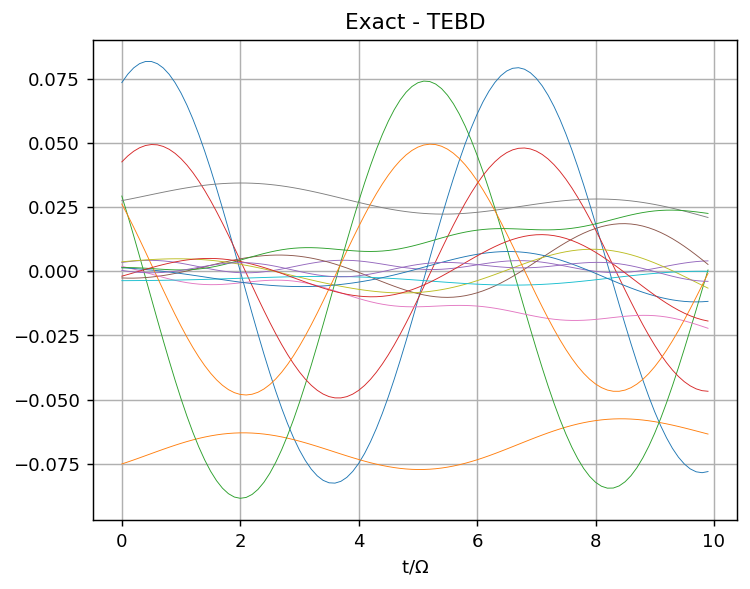

In [43]:
### PLOT
# here I plot the difference in the expectation values

t = np.arange(0, T, dt)

plt.figure(dpi=130)#figsize=(9, 6))

for key in keys:
    plt.plot(t, diff_avrg[key], linewidth=0.5, label=key)
    
#avrg = []
#for i in range(len(t)):
#    avrg.append(sum((diff[key][i] for key in keys))/15)
#lt.plot(t, avrg, linewidth=2, linestyle='dashed', color='black')

plt.grid()
plt.xlabel(r't/$\Omega$')
plt.title('Exact - TEBD')

fig = plt.gcf()
#plt.legend()
plt.show()

#fig.savefig('./pictures/consistency_check_3_errors.pdf', dpi=150)